### **1. Importing the necessary libraries**

In [1]:
import re
import os
import nltk
import json
import spacy
import pickle
import string
import time
import logging
import numpy as np
import seaborn as sns
import networkx as nx
import pandas as pd
from tqdm import tqdm
from spacy import displacy
import plotly.express as px
from selenium import webdriver
from pyvis.network import Network
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords 
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import community.community_louvain as community_louvain

%matplotlib inline
sns.set_style('darkgrid')

### **2. Prepping the Characters**

In [5]:
character_df = pd.read_csv("characters.csv")
character_df.rename(columns = {'0':'character'}, inplace = True)
character_df.head()

,Unnamed: 0,character
0,0,Hannah Abbott
1,1,Aragog
2,2,Ludo Bagman
3,3,Bathilda Bagshot
4,4,Bane (Centaur)


In [6]:
character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x)) 
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])
character_df = character_df[["character", "character_firstname"]]
character_df

,character,character_firstname
0,Hannah Abbott,Hannah
1,Aragog,Aragog
2,Ludo Bagman,Ludo
3,Bathilda Bagshot,Bathilda
4,Bane,Bane
...,...,...
191,Ron Weasley,Ron
192,Winky,Winky
193,Oliver Wood,Oliver
194,Corban Yaxley,Corban


In [4]:
indice_dumbeldore = character_df[character_df['character'].str.contains('Dumbledore')].index
indice_snape = character_df[character_df['character'].str.contains('Snape')].index
indice_hagrid = character_df[character_df['character'].str.contains('Hagrid')].index
indice_voldemort = character_df[character_df['character'].str.contains('Voldemort')].index
indice_malfoy = character_df[character_df['character'].str.contains('Malfoy')].index

print(indice_dumbeldore)
print(indice_snape)
print(indice_hagrid)
print(indice_voldemort)
print(indice_malfoy)

Int64Index([43, 44, 45, 46, 47], dtype='int64')
Int64Index([166], dtype='int64')
Int64Index([84], dtype='int64')
Int64Index([182], dtype='int64')
Int64Index([107, 108, 109, 110], dtype='int64')


In [5]:
character_df.loc[44, 'character_firstname'] = 'Dumbledore'
character_df.loc[166, 'character_firstname'] = 'Snape'
character_df.loc[84, 'character_firstname'] = 'Hagrid'
character_df.loc[182, 'character_firstname'] = 'Voldemort'
character_df.loc[107, 'character_firstname'] = 'Malfoy'

### **3. Analyzing All the Books**

In [7]:
from utils import ner, get_ne_list_per_sentence, filter_entity, create_relationships

In [8]:
# Initialize empty list for graphs from books and Sort dir entries by name
all_books = [b for b in os.scandir('Harry-Potter/Book_Text') if '.txt' in b.name]
all_books.sort(key=lambda x: x.name)

In [9]:
%%time

books = []
relationships = []
entities = []
books_graph = []

for book in tqdm(all_books):
    book_text = ner(book)
    books.append(book_text)
    
    # Get list of entities per sentences
    sent_entity_df = get_ne_list_per_sentence(book_text)
    
    # Select only character entities
    sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

    # Filter out sentences that don't have any character entities
    sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
    
    # Take only first name of characters
    sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] for item in x])                                                                                                         
    entities.append(sent_entity_df_filtered)
    
    # Create relationship df
    relationship_df = create_relationships(df = sent_entity_df_filtered, window_size = 5)
    relationships.append(relationship_df)
    
    # Create a graph from a pandas dataframe
    G = nx.from_pandas_edgelist(relationship_df, 
                                source = "source", 
                                target = "target", 
                                edge_attr = "value", 
                                create_using = nx.Graph())     
    
    books_graph.append(G) 

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]<timed exec>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [41:43<00:00, 357.65s/it]

Wall time: 41min 43s


In [10]:
print(len(books))
print(len(relationships))
print(len(entities))
print(len(books_graph))

7
7
7
7


**Saving the files**

In [24]:
with open("pickles/books.pkl", "wb") as fp:  
    pickle.dump(books, fp)  
with open("pickles/relationships.pkl", "wb") as fp:   
    pickle.dump(relationships, fp)  
with open("pickles/books_graph.pkl", "wb") as fp:   
    pickle.dump(books_graph, fp) 
with open("pickles/entities.pkl", "wb") as fp:   
    pickle.dump(entities, fp)

NotImplementedError: [E112] Pickling a span is not supported, because spans are only views of the parent Doc and can't exist on their own. A pickled span would always have to include its Doc and Vocab, which has practically no advantage over pickling the parent Doc directly. So instead of pickling the span, pickle the Doc it belongs to or use Span.as_doc to convert the span to a standalone Doc object.

**loading the files**

In [6]:
with open("pickles/books.pkl", "rb") as fp:
    b = pickle.load(fp)
with open("pickles/relationships.pkl", "rb") as fp:
    r = pickle.load(fp)
with open("pickles/books_graph.pkl", "rb") as fp:
    bg = pickle.load(fp)
#with open("pickles/entities.pkl", "rb") as fp:
#    e = pickle.load(fp)

### **4. Vizualizing all graphs** 

In [80]:
def make_graph(books_graph, name):
    scale=1
    new_degree = dict(books_graph.degree)
    new_degree.update((x, scale*y) for x, y in new_degree.items())
    
    new_communities = community_louvain.best_partition(books_graph)
    node_degree = dict(books_graph.degree)
    nx.set_node_attributes(books_graph, new_communities, 'group')
    nx.set_node_attributes(books_graph, new_degree, 'size')

    com_net = Network(notebook = True, width="1500px", height="1000px", bgcolor='#222222', font_color='white', )
    com_net.force_atlas_2based(spring_length=50)
    com_net.from_nx(books_graph)
    com_net.show_buttons(filter_="physics")
    com_net.show("new_graphs/" + name + ".html")

In [81]:
make_graph(books_graph[0], 'book1')
make_graph(books_graph[1], 'book2')
make_graph(books_graph[2], 'book3')
make_graph(books_graph[3], 'book4')
make_graph(books_graph[4], 'book5')
make_graph(books_graph[5], 'book6')
make_graph(books_graph[6], 'book7')

new_graphs/book1.html
new_graphs/book2.html
new_graphs/book3.html
new_graphs/book4.html
new_graphs/book5.html
new_graphs/book6.html
new_graphs/book7.html


### **5. Making the graph for the whole series** 

In [93]:
cumulative_df = pd.concat(relationships)
cumulative_df = cumulative_df.groupby(["source","target"], sort=False, as_index=False).sum()                                      
cumulative_sorted_df = cumulative_df.sort_values(by='value', ascending=False)
cumulative_sorted_df.head(10)

,source,target,value
24,Harry,Ron,23613
4,Dumbledore,Harry,8360
36,Harry,Hermione,5667
48,Hermione,Ron,4895
70,Harry,Snape,4733
5,Hagrid,Harry,4234
3,Harry,Voldemort,3772
42,Harry,Malfoy,2940
7,Dudley,Harry,1937
49,Harry,Neville,1904


In [96]:
cumulative_graph = nx.from_pandas_edgelist(cumulative_sorted_df, 
                                source = "source", 
                                target = "target", 
                                edge_attr = "value", 
                                create_using = nx.Graph())
make_graph(cumulative_graph, 'cumulative')

new_graphs/cumulative.html


### **6. Evolution of Character Importance Over Time** 

In [75]:
#Creating a list of degree centrality of all the books
evol = [nx.degree_centrality(book) for book in bg]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)

degree_evol_df.to_csv('character_evolution.csv')

In [60]:
df = pd.read_csv('character_evolution.csv')
index = ['Philosopher\'s Stone',
         'Chamber of Secrets',
         'Prisoner of Azkaban',
         'Goblet of Fire',
         'Order of the Phoenix',
         'Half-Blood Prince',
         'Deathly Hallows']

df = df.set_index(pd.Index(index))

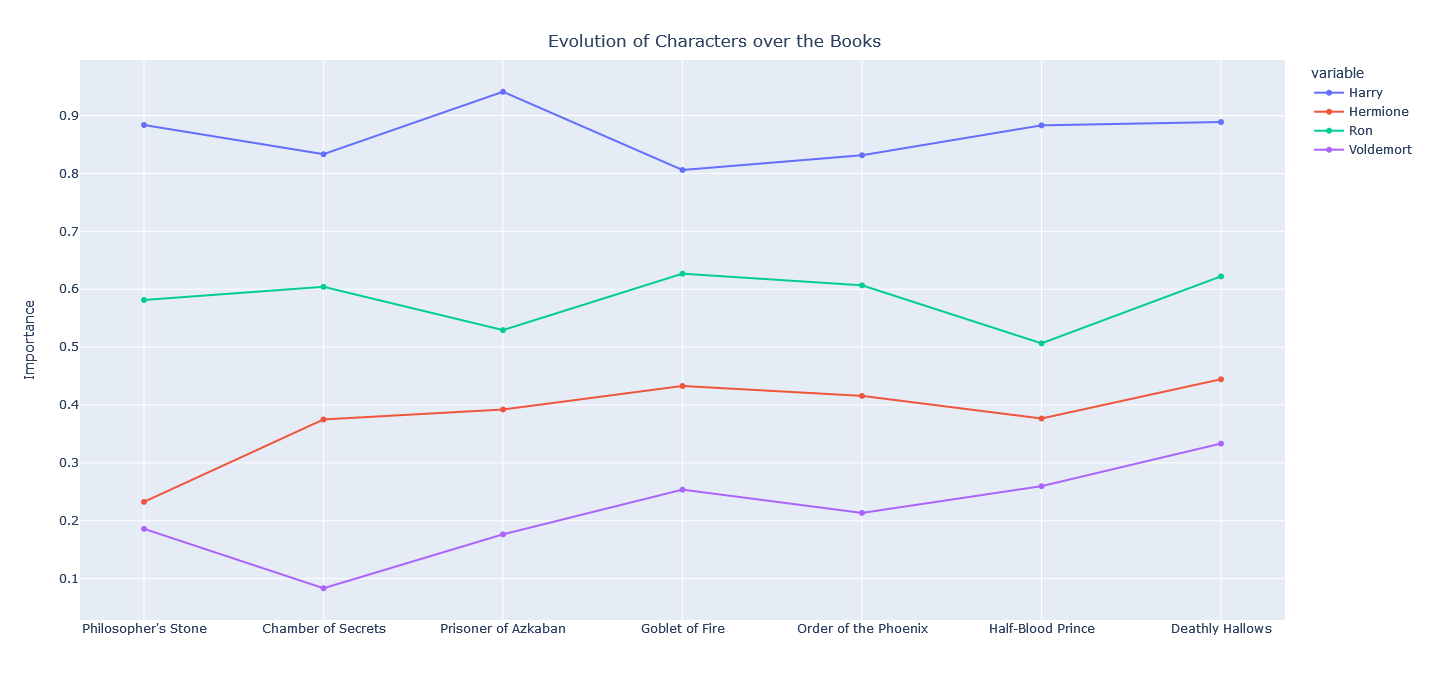

In [74]:
character_list = ["Harry", "Hermione", "Ron", "Voldemort"]
fig = px.line(df[character_list], markers=True) 

fig.update_layout(height=700,
                  width=1000, 
                  xaxis_title="",
                  yaxis_title="Importance",
                  title={'text': "Evolution of Characters over the Books",
                         'y': 0.95,
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'})

fig.show()

In [62]:
df

,Unnamed: 0,Dumbledore,Voldemort,Godric,Albus,James,Harry,Hagrid,Dudley,Petunia,...,Xenophilius,Elphias,Bathilda,Albert,Dirk,Gornuk,Gellert,Scabior,Bogrod,Helena
Philosopher's Stone,0,0.325581,0.186047,0.023256,0.046512,0.023256,0.883721,0.418605,0.209302,0.046512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chamber of Secrets,1,0.333333,0.083333,NaN,0.041667,NaN,0.833333,0.354167,0.083333,0.083333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Prisoner of Azkaban,2,0.313725,0.176471,NaN,NaN,0.215686,0.941176,0.274510,0.078431,0.078431,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Goblet of Fire,3,0.507463,0.253731,NaN,0.029851,NaN,0.805970,0.373134,0.104478,0.059701,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Order of the Phoenix,4,0.460674,0.213483,NaN,NaN,0.089888,0.831461,0.303371,0.123596,0.044944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Half-Blood Prince,5,0.519481,0.259740,NaN,0.025974,0.051948,0.883117,0.259740,0.051948,0.038961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Deathly Hallows,6,0.422222,0.333333,0.100000,0.188889,0.133333,0.888889,0.222222,0.088889,0.088889,...,0.122222,0.055556,0.122222,0.033333,0.111111,0.077778,0.044444,0.055556,0.066667,0.011111
